<a href="https://colab.research.google.com/github/giancarlohc/Applied-AI-in-Transportation/blob/main/Project/ProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install researchpy
import researchpy as rp

url = "https://raw.githubusercontent.com/giancarlohc/Applied-AI-in-Transportation/main/ProjectAssignmentData/Dataset-PT.csv"
dataset = pd.read_csv(url,skiprows=[0])

In [10]:
dataset

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,74,44,341,12,...,0,0,0,0,1,1,0,0,0,1
545099,20220630,4,41362,24,330,15,34,92,344,12,...,0,0,0,0,1,1,0,0,0,1
545100,20220630,4,41362,25,339,17,63,43,330,12,...,0,0,0,0,1,1,0,0,0,1
545101,20220630,4,41362,26,331,0,35,58,339,12,...,0,0,0,0,1,1,0,0,0,1


In [7]:
np.mean(dataset)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Calendar_date                        2.022036e+07
route_id                             4.000000e+00
bus_id                               4.296080e+04
stop_sequence                        1.400000e+01
arrival_delay                        1.349722e+02
dwell_time                           3.199467e+01
travel_time_for_previous_section     7.144097e+01
scheduled_travel_time                1.059184e+02
upstream_stop_delay                  1.356519e+02
origin_delay                         7.510724e+01
previous_bus_delay                   1.343793e+02
previous_trip_travel_time            7.318384e+01
traffic_condition                    7.315493e+01
recurrent_delay                      7.275001e+01
factor(weather)Light_Rain            2.446877e-02
factor(weather)Light_Snow            1.783149e-02
factor(weather)Normal                9.447224e-01
factor(weather)Rain                  6.191490e-03
factor(weather)Snow                  6.785873e-03
factor(temperature)Cold              1.127347e-01


(array([2.70000e+01, 0.00000e+00, 1.00000e+00, 7.00000e+01, 1.18000e+02,
        4.97970e+04, 4.70278e+05, 2.39390e+04, 7.75000e+02, 9.80000e+01]),
 array([-3493., -2918., -2343., -1768., -1193.,  -618.,   -43.,   532.,
         1107.,  1682.,  2257.]),
 <BarContainer object of 10 artists>)

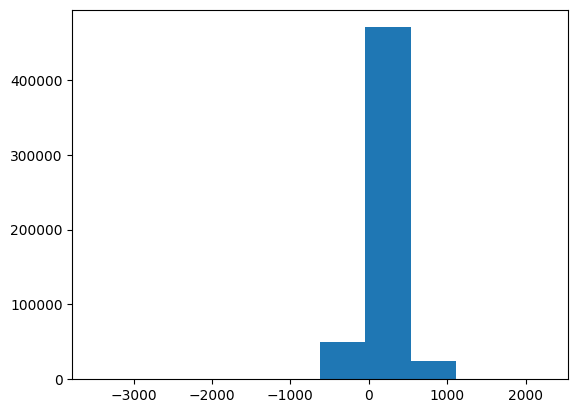

In [9]:
plt.hist(dataset["arrival_delay"])

<Axes: >

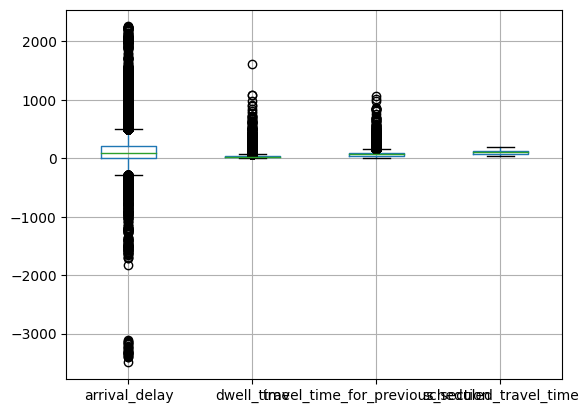

In [14]:
dataset.boxplot(column=["arrival_delay","dwell_time","travel_time_for_previous_section","scheduled_travel_time"])

<Axes: >

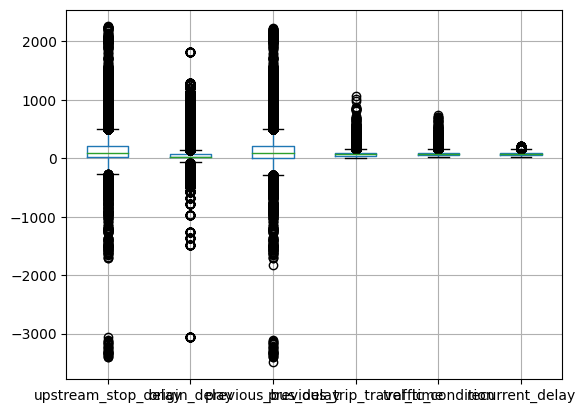

In [15]:
dataset.boxplot(column=["upstream_stop_delay","origin_delay","previous_bus_delay","previous_trip_travel_time","traffic_condition","recurrent_delay"])

In [21]:
np.unique(dataset.isna())

array([False])

In [24]:
correlation_matrix = dataset[["arrival_delay","dwell_time","travel_time_for_previous_section","scheduled_travel_time","upstream_stop_delay","origin_delay","previous_bus_delay","previous_trip_travel_time","traffic_condition","recurrent_delay"]].corr()

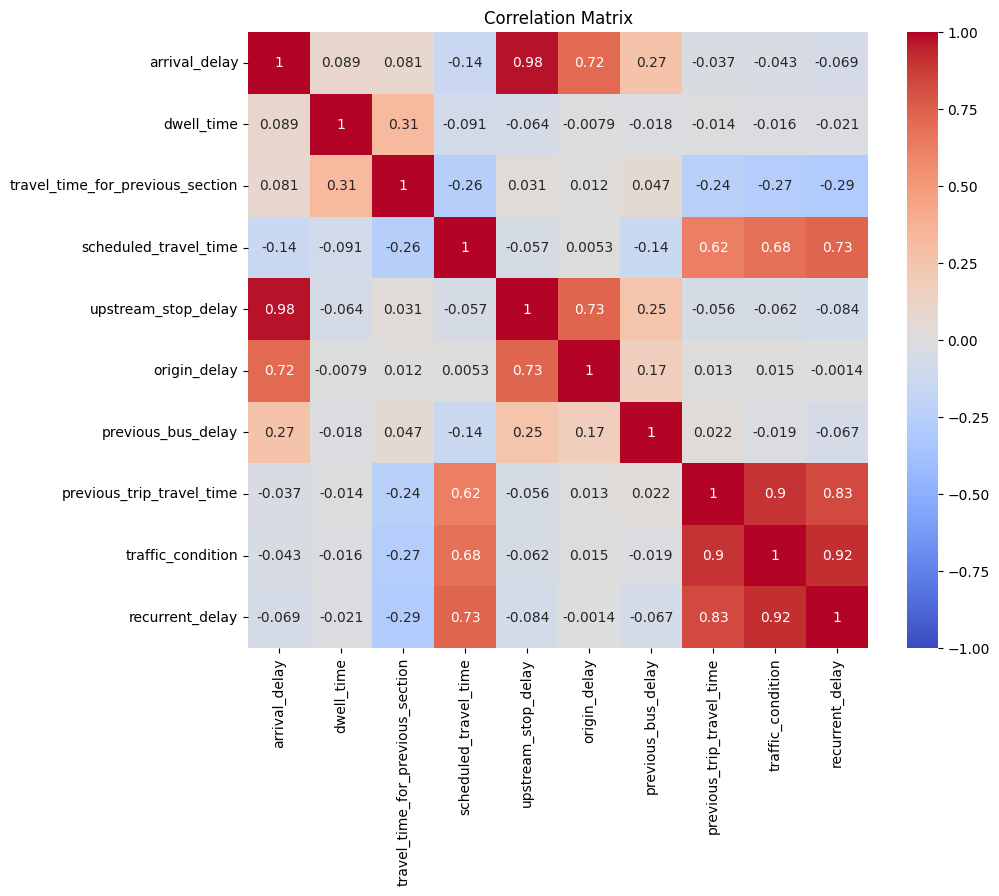

In [25]:
plt.figure(figsize=(10, 8))  # Set figure size for better visualization
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [29]:
rp.summary_cat(dataset[["weather", "temperature","day_of_week","time_of_day"]])

/usr/local/lib/python3.10/dist-packages/researchpy/summary.py:225: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ix, df_col in group1.iteritems():


,Variable,Outcome,Count,Percent
0,weather,Normal,514971,94.47
1,,Light Rain,13338,2.45
2,,Light Snow,9720,1.78
3,,Snow,3699,0.68
4,,Rain,3375,0.62
5,temperature,Normal,473877,86.93
6,,Cold,61452,11.27
7,,Extra cold,9774,1.79
8,day_of_week,weekday,418149,76.71
9,,weekend,126954,23.29
